In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import hamiltonians as hamiltonians
from pauli_matrices import *
import quantum_tools as qt

In [2]:
# Define frequencies
natural_freq = 10 * 10**9
driving_freq = 10 * 10**9
rabi_freq = 5 * 10**6   # Rabi frequency
modulation_freq = rabi_freq/2.404826 # Modulation frequency




# Integration parameters
tol = 10**-6
evaluation_points = 1000
evaluation_time = 10*10**-6



In [6]:
import numpy as np
import multiprocess as mp  # Use multiprocess instead of multiprocessing
import dill  # For more robust serialization

detunings = np.linspace(0, 2*10e6, 1000)

# Define processing function
def process_detuning(detuning, **kwargs):
    """Process a single detuning value with given parameters"""
    # Extract parameters from kwargs
    natural_freq = kwargs['natural_freq']
    evaluation_time = kwargs['evaluation_time']
    evaluation_points = kwargs['evaluation_points']
    driving_freq = kwargs['driving_freq']
    rabi_freq = kwargs['rabi_freq']
    modulation_freq = kwargs['modulation_freq']

    
    fids_1 = []
    fids_2 = []
    fids_seperate = []
    fids_together = []

    fid_combined_Us = []

    t, U1s = qt.calculate_unitaries(1, evaluation_time, evaluation_points, hamiltonians.smart_rwa,
                        driving_freq=driving_freq,
                        natural_freq =  natural_freq, 
                        rabi_freq=rabi_freq,
                        modulation_freq=modulation_freq)
    fid_1 = qt.calculate_fidelities(np.eye(2), U1s, 2)




    t, U2s = qt.calculate_unitaries(1, evaluation_time, evaluation_points, hamiltonians.smart_rwa,
                        driving_freq=driving_freq,
                        natural_freq =  natural_freq+detuning, 
                        rabi_freq=rabi_freq,
                        modulation_freq=modulation_freq)
    fid_2 = qt.calculate_fidelities(np.eye(2), U2s, 2)






    fid_seperate = (np.abs((6*fid_1-2)*(6*fid_2-2))+4)/20

    fids_1.append(fid_1)
    fids_2.append(fid_2)
    fids_seperate.append(fid_seperate)



    natural_freqs = np.array([natural_freq, natural_freq+detuning])
    # Recalculate the unitaries with the updated Hamiltonian

    times, Us = qt.calculate_unitaries(2, evaluation_time, evaluation_points, hamiltonians.smart_rwa_multiple, 
                                                driving_freq=driving_freq, natural_freqs =  natural_freqs, rabi_freq=rabi_freq,
                                                modulation_freq = modulation_freq, coupling = 0)

    # Calculate the fidelities for the unitaries at all times
    fid_together = qt.calculate_fidelities(np.eye(4), Us, 2**2)
    fids_together.append(fid_together)
    return (times, fid_1, fid_2, fid_seperate, fid_combined_Us, fid_together)

# Package parameters
params = {
    'natural_freq': natural_freq,
    'evaluation_time': evaluation_time,
    'evaluation_points': evaluation_points,
    'driving_freq': driving_freq,
    'rabi_freq': rabi_freq,
    'modulation_freq': modulation_freq
}

# Create pool with dill serialization
if __name__ == '__main__':
    with mp.Pool() as pool:
        # Use partial to fix the kwargs
        worker = dill.dumps(lambda x: process_detuning(x, **params))
        results = pool.map(dill.loads(worker), detunings)

# Unpack results
times, fids_1, fids_2, fids_seperate, fid_combined_Us, fids_together = zip(*results)

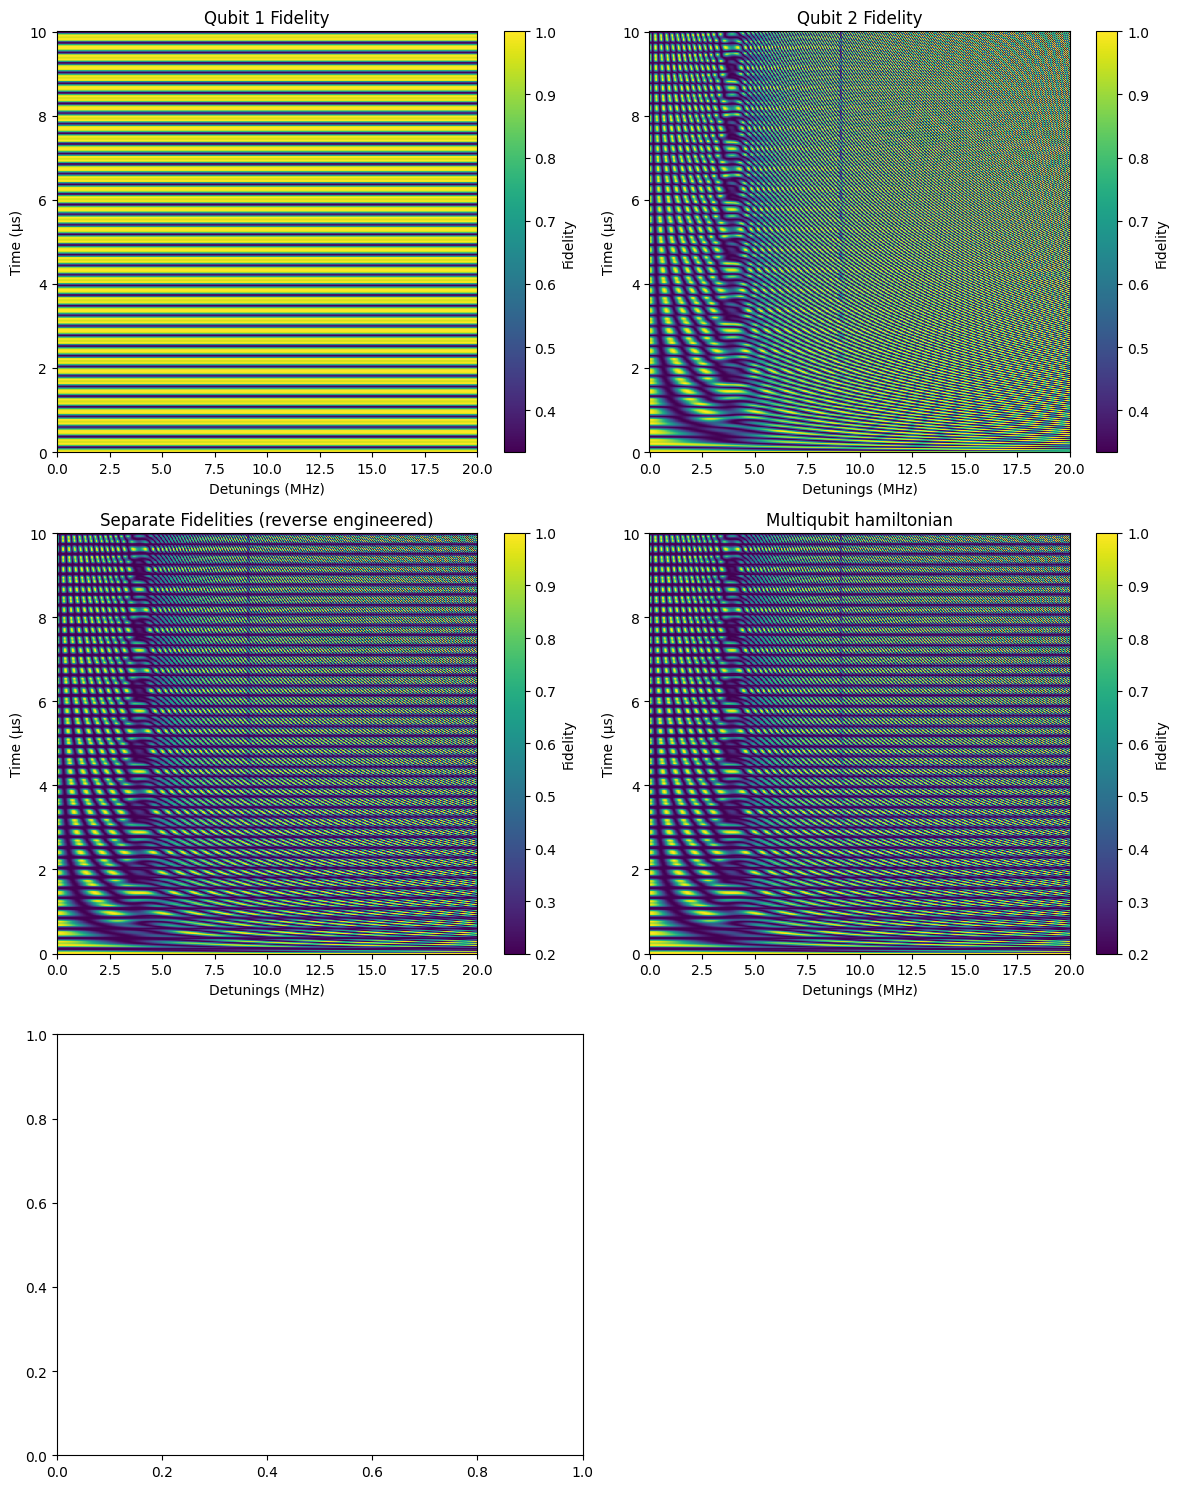

In [7]:
# Convert detunings to MHz and times to microseconds
detunings_mhz = detunings / 1e6

times_us = times[0] * 1e6


# Create a figure with 5 subplots in a 3x2 grid
fig, ((ax1, ax2), (ax3, ax4), (ax5, _)) = plt.subplots(3, 2, figsize=(12, 15))



# Create color plots
im1 = ax1.pcolormesh(detunings_mhz, times_us, np.array(fids_1).T, shading='auto', cmap='viridis')
im2 = ax2.pcolormesh(detunings_mhz, times_us, np.array(fids_2).T, shading='auto', cmap='viridis')
im3 = ax3.pcolormesh(detunings_mhz, times_us, np.array(fids_seperate).T, shading='auto', cmap='viridis')
im4 = ax4.pcolormesh(detunings_mhz, times_us, np.array(fids_together).T, shading='auto', cmap='viridis')
# im5 = ax5.pcolormesh(detunings_mhz, times_us, np.array(fid_combined_Us[0]).T, shading='auto', cmap='viridis')


# Add colorbars
fig.colorbar(im1, ax=ax1, label='Fidelity')
fig.colorbar(im2, ax=ax2, label='Fidelity')
fig.colorbar(im3, ax=ax3, label='Fidelity')
fig.colorbar(im4, ax=ax4, label='Fidelity')
# fig.colorbar(im5, ax=ax5, label='Fidelity')

# Set labels and titles
ax1.set_xlabel('Detunings (MHz)')
ax1.set_ylabel('Time (µs)')
ax1.set_title('Qubit 1 Fidelity')

ax2.set_xlabel('Detunings (MHz)')
ax2.set_ylabel('Time (µs)')
ax2.set_title('Qubit 2 Fidelity')

ax3.set_xlabel('Detunings (MHz)')
ax3.set_ylabel('Time (µs)')
ax3.set_title('Separate Fidelities (reverse engineered)')

ax4.set_xlabel('Detunings (MHz)')
ax4.set_ylabel('Time (µs)')
ax4.set_title('Multiqubit hamiltonian')

# ax5.set_xlabel('Detunings (MHz)')
# ax5.set_ylabel('Time (µs)')
# ax5.set_title('Combined Fidelities (Tensor Product)')

# Remove the empty subplot
_.remove()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()